<a href="https://colab.research.google.com/github/alexjercan/asr-toolkit/blob/master/examples/02_QuartzNet_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependecies

In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

from IPython.display import clear_output
clear_output()

In [2]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
!python -m pip install torchaudio > /dev/null
!python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-94u0fn1c


In [31]:
!pip install wandb

In [3]:
!pip install youtube-dl > /dev/null

In [46]:
%rm -rf asr
!git clone https://github.com/alexjercan/asr-toolkit.git asr > /dev/null

Cloning into 'asr'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 73 (delta 38), reused 36 (delta 14), pack-reused 0
Unpacking objects: 100% (73/73), done.


## Scripts

In [5]:
def download_from_google_drive(file_id, file_name):
    # download a file from the Google Drive link
    !rm -f ./cookie
    print(f'Downloading https://drive.google.com/file/d/{file_id}/view?usp=sharing into {file_name}')
    !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
    confirm_text = !awk '/download/ {print $NF}' ./cookie
    confirm_text = confirm_text[0]
    !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

In [6]:
file_ids=[]
file_names=[]

for file_id, file_name in zip(file_ids, file_names):
    download_from_google_drive(file_id, file_name)

In [33]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Main

In [16]:
import os
import re

import nemo
import nemo.collections.asr as nemo_asr
import torch
import numpy as np
import augment
import torchaudio
import torchaudio.datasets

from datetime import datetime as dt
import wandb

from asr.metrics import ASRMetricFunction
from asr.visualisation import play_audio, print_err_html, print_stats, plot_waveform
from asr.general import set_parameter_requires_grad, load_checkpoint, save_checkpoint
from asr.utils import ChainRunner
from asr.models import QuartzNet
from asr.datasets import librispeech_dataloader
from IPython.display import YouTubeVideo

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 CPU


In [17]:
# Load pretrained QuartzNet model
nemo_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2021-08-09 13:07:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-08-09 13:07:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2021-08-09 13:07:27 common:681] Instantiating model from pre-trained checkpoint
[NeMo I 2021-08-09 13:07:28 features:252] PADDING: 16
[NeMo I 2021-08-09 13:07:28 features:269] STFT using torch
[NeMo I 2021-08-09 13:07:29 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [18]:
ROOT = os.path.join(".")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

vocab = list(map(lambda x: x.upper(), nemo_model.decoder.vocabulary)) + ['<pad>']
BLANK = len(vocab) - 1
labels = range(len(vocab))
data = dict(zip(vocab, labels))

DICTIONARY = data
LABELS = {v:k for k, v in DICTIONARY.items()}

In [19]:
hyper_params = {
    "dictionary": DICTIONARY,
    "labels": LABELS,
    "blank": BLANK,
    "batch_size": 2,
    "num_epochs": 1,
    "learning_rate": 1e-3
}

In [5]:
wandb.init(project="QuartzNet_with_PyTorch", config=hyper_params)

wandb: Currently logged in as: alexjercan (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
# Generate a random shift applied to the speaker's pitch
def random_pitch_shift():
    return np.random.randint(-300, 300)

# Generate a random size of the room
def random_room_size():
    return np.random.randint(0, 100)

# TODO: generate more augmentations
effect_chain = augment.EffectChain()
# The pitch effect changes the sampling ratio; we have to compensate for that.
# Here, we specify 'quick' options on both pitch and rate effects, to speed up things
effect_chain.pitch("-q", random_pitch_shift).rate("-q", 16_000)
# Next effect we add is `reverb`; it adds makes the signal to have two channels,
# which we combine into 1 by running `channels` w/o parameters
effect_chain.reverb(50, 50, random_room_size).channels()
# Futher, we add an effect that randomly drops one 50ms subsequence
effect_chain.time_dropout(max_seconds=50 / 1000)

train_transform = ChainRunner(effect_chain)

In [21]:
# Create the dataloaders
_, train_dataloader = librispeech_dataloader(DICTIONARY, root=ROOT, urls=["train-clean-100"], folder_in_archive="LibriSpeech", batch_size=hyper_params["batch_size"], transform=train_transform, shuffle=True, download=True)
_, val_dataloader = librispeech_dataloader(DICTIONARY, root=ROOT, urls=["dev-clean"], folder_in_archive="LibriSpeech", batch_size=hyper_params["batch_size"]*2, download=True)
_, test_dataloader = librispeech_dataloader(DICTIONARY, root=ROOT, urls=["test-clean"], folder_in_archive="LibriSpeech", batch_size=hyper_params["batch_size"]*2, download=True)
_, val_other_dataloader = librispeech_dataloader(DICTIONARY, root=ROOT, urls=["dev-other"], folder_in_archive="LibriSpeech", batch_size=hyper_params["batch_size"]*2, download=True)
_, test_other_dataloader = librispeech_dataloader(DICTIONARY, root=ROOT, urls=["test-other"], folder_in_archive="LibriSpeech", batch_size=hyper_params["batch_size"]*2, download=True)

In [8]:
# Create model
model = QuartzNet(nemo_model, hyper_params["labels"], hyper_params["blank"])
model = model.to(DEVICE)

set_parameter_requires_grad(model, True)

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=hyper_params["learning_rate"])
scaler = torch.cuda.amp.GradScaler()

[NeMo W 2021-08-09 12:48:56 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning:
    
    torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
    
    


In [9]:
wandb.watch(model, log_freq=100)

[]

In [ ]:
# Train model
if os.path.isfile("checkpoint-epoch-000.pth"):
    model = load_checkpoint(model, "checkpoint-epoch-000.pth", DEVICE)
else:
    output_dir = os.path.join("./runs", re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

    for epoch_idx in range(hyper_params["num_epochs"]):
        metric_fn = ASRMetricFunction()
        train_loss, val_loss = model.train_model(train_dataloader, val_dataloader, metric_fn, optimizer, scaler, epoch_idx)
        wandb.log({**{f"train_{k}":v for k, v in train_loss.items()}, **{f"val_{k}":v for k, v in val_loss.items()}, **{f"val_{k}":v for k, v in metric_fn.error_avg.items()}, "epoch": epoch_idx})
        print(metric_fn.show())

    file_name = 'checkpoint-epoch-%03d.pth' % (epoch_idx)
    save_checkpoint(model, output_dir, file_name)

In [ ]:
# Test model
metric_fn = ASRMetricFunction()
test_loss = model.test_model(test_dataloader, metric_fn)
wandb.log({**{f"test_{k}":v for k, v in test_loss.items()}, **{f"val_{k}":v for k, v in metric_fn.error_avg.items()}})
print(metric_fn.show())

In [33]:
# Red colors are missing word, Green colors are insertion word. Yellow colors are substitution word and the references are in parenthesis.
test_clean = torchaudio.datasets.LIBRISPEECH(root=ROOT, url="test-clean", folder_in_archive="LibriSpeech", download=True)
data = []

for i, (waveform, sample_rate, utterance, _, _, _) in enumerate(test_clean):
    transcription = model.inference(waveform[0].unsqueeze(0).to(DEVICE), torch.tensor([waveform.shape[-1]]).to(DEVICE))[0]

    r = utterance.split(" ")
    h = transcription.split(" ")

    play_audio(waveform, sample_rate)
    html, err = print_err_html(r, h)

    data.append([wandb.Audio(waveform[0].numpy(), sample_rate=sample_rate), wandb.Html(data=html)])

    if i > 2:
        break

wandb.log({"Inference Examples": wandb.Table(columns=["inputs", "diffs"], data=data)})

ERR=10.7143


ERR=0.0000


ERR=0.0000


ERR=0.0000


In [32]:
# Red colors are missing word, Green colors are insertion word. Yellow colors are substitution word and the references are in parenthesis.
test_clean = torchaudio.datasets.LIBRISPEECH(root=ROOT, url="test-clean", folder_in_archive="LibriSpeech", download=True)
data = []

for i, (waveform, sample_rate, utterance, _, _, _) in enumerate(test_clean):
    transcription = model.inference(waveform[0].unsqueeze(0).to(DEVICE), torch.tensor([waveform.shape[-1]]).to(DEVICE))[0]

    r = list(utterance)
    h = list(transcription)

    play_audio(waveform, sample_rate)
    html, err = print_err_html(r, h)

    data.append([wandb.Audio(waveform[0].numpy(), sample_rate=sample_rate), wandb.Html(data=html)])

    if i > 2:
        break

wandb.log({"Inference Examples Characters": wandb.Table(columns=["inputs", "diffs"], data=data)})

ERR=1.8987


ERR=0.0000


ERR=0.0000


ERR=0.0000


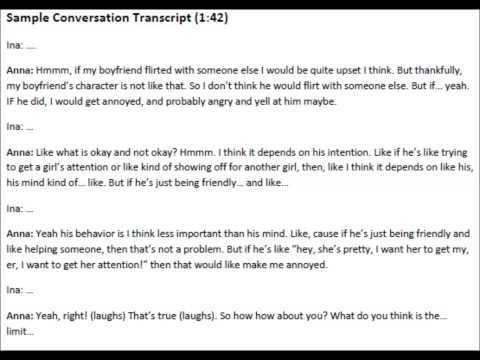

In [15]:
YOUTUBE_ID = 'ayrYA_FtMfI'

YouTubeVideo(YOUTUBE_ID)

In [16]:
TRANSCRIPT = "ANNA DO YOU GET ANNOYED WHEN YOUR BOYFRIEND FLIRTS WITH SOMEONE ELSE YES MY BOYFRIEND FLIRT SOMEONE ELSE I WOULD BE QUITE UPSET I THINK THANKFULLY MY BOYFRIEND CHARACTER IS NOT LIKE THAT I DON'T THINK SO HE WOULD FLIRT WITH SOMEONE ELSE BUT IF BUT IF BUT IF HE DID I WOULD GET ANNOYED AND PROBABLY ANGRY AND YELLING AND MAYBE SO WHAT DO YOU THINK THE LIMITATION OF A FLIRT LIKE WHAT IS OK AND NOT OK YEAH I THINK IT DEPENDS IN HIS INTENTION LIKE HIS TRYING TO GET A GIRL ATTENTION OR LIKE KIND OFF SHOWING OF FOR ANOTHER GIRL THEN I THINK IT DEPENDS LIKE HIS MIND BUT IF HE IS JUST LIKE BEING FRIENDLY HIS BEHAVIOR YEAH HIS BEHAVIOR IS I THINK LESS IMPORTANT THAN HIS MIND LIKE BECAUSE IF HIS JUST FRIENDLY LIKE HELPING SOMEONE THEN THAT'S NOT A PROBLEM BUT IF HE'S JUST LIKE HEY SHE'S PRETTY I WANT TO GET HER ATTENTION THEN WOULD GET ANNOYED YEAH BUT I THINK THAT'S VERY SUBTLE YEAH RIGHT YOU'RE NOT REALLY KNOW THAT IS TRUE SO HOW ABOUT YOU WHAT DO YOU IS THE I THINK"

In [17]:
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 example.wav

[youtube] ayrYA_FtMfI: Downloading webpage
[download] Destination: downloaded.m4a
[download] 100% of 1.56MiB in 00:00
[ffmpeg] Correcting container in "downloaded.m4a"
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.m4a (pass -k to keep)


In [18]:
waveform, sample_rate = torchaudio.load("example.wav")

Sample Rate: 16000
Shape: (1, 1648431)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:    -0.000
 - Std Dev:  0.082

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



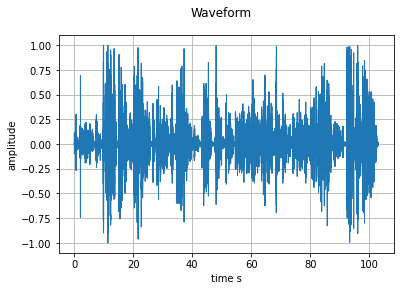

In [19]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [20]:
transcription = model.inference(waveform[0].unsqueeze(0).to(DEVICE), torch.tensor([waveform.shape[-1]]).to(DEVICE))[0]

print(transcription)

MHMOH ANN DO YOU GET ANNOYED WHEN YOUR BOYFRIEND FLIRTS WITH SOMEONE ELSE HM IF MY BOYFRIEND WLORS I SOMEONE ELSE I WOULD BE QUITE UPSET I THINK BUT THANKFULLY MY BOYFRIEND CHARACTER IS NOT LIKE THAT SO I DON'T THINK HE WOULD FLIRT WITH SOME ONE ELSE BUT IF IF YET IF HE DID I WOULD GET ANNOYED AND PROBABLY ANGRY AN YELL AT  MABE A LIMITATION OF TE PART LIK WHAT IS O KA AN OTOKA HUM I THINK IT DEPENDS ON HIS INTENTION LIKE IF HE'S LIKE TRYING TO GET A GIRL'S ATTENTION OR LIKE KIND OF SHOWING OFF FOR ANOTHER GIRL THEN LIKE I THINK IT DEPENDS ON LIKE HIS HIS MIND KIND OF LIKE BUT IF HE'S JUST BEING FRIENDLY AND LATER YEAH HIS BEHAVIOR IS I THINK LESS IMPORTANT THAN HIS IN MIGHT LIKE CAUSE IF HE'S JUST BEING FRIENDLY AND LIKE HELPING SOME ONE THEN THAT'S NOT A PROBLEM BUT IF HE'S LIKE HEY SHE'S PRETTY I WANT HER TO GET MY I WANT TO GET HER ATTENTION THENTHOT WOULD LIKE MAKE ME AHO BUT I THINK THAT'S VERY SUBTLE YES RIGHT TIS TRUE SO HOW HOW ABOUT YOU A WHA WHAT DO YOU THINK IS THE LINIC


In [21]:
r = TRANSCRIPT.split(" ")
h = transcription.split(" ")

html, err = print_err_html(r, h)

ERR=42.7083


In [22]:
r = list(TRANSCRIPT)
h = list(transcription)


html, err = print_err_html(r, h)

ERR=25.8763
